In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install albumentations --quiet
!pip install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00:00:0100:01


### Imports

In [3]:
import albumentations as A
import torch
import json
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights, ConvNeXt_Tiny_Weights, ConvNeXt_Large_Weights
from torchmetrics.classification import F1Score
from scipy import ndimage
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import StratifiedKFold
from typing import Optional, Tuple, Dict, Any
from tqdm.autonotebook import tqdm
from PIL import Image
import seaborn as sns
import random
import timm
seed = 42

In [4]:
train_imgs = '/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data'
test_imgs = '/kaggle/input/slideandseekclasificationlandslidedetectiondataset/test_data/test_data'
train_dir = '/kaggle/input/slideandseekclasificationlandslidedetectiondataset/Train.csv'
test_dir = '/kaggle/input/slideandseekclasificationlandslidedetectiondataset/Test.csv'
PARENT_PATH = '/kaggle/working/'

In [5]:
train = pd.read_csv(train_dir)
test = pd.read_csv(test_dir)
train['numpy_path'] = train['ID'].apply(lambda x: train_imgs + '/' + f"{x}.npy")
test['numpy_path'] = test['ID'].apply(lambda x: test_imgs + '/' + f"{x}.npy")
train.head()

,ID,label,numpy_path
0,ID_HUD1ST,1,/kaggle/input/slideandseekclasificationlandsli...
1,ID_KGE2HY,1,/kaggle/input/slideandseekclasificationlandsli...
2,ID_VHV9BL,1,/kaggle/input/slideandseekclasificationlandsli...
3,ID_ZT0VEJ,0,/kaggle/input/slideandseekclasificationlandsli...
4,ID_5NFXVY,0,/kaggle/input/slideandseekclasificationlandsli...


In [6]:
sample_array = np.load(train['numpy_path'][0])
print(sample_array.shape)

(64, 64, 12)


In [7]:
BAND_NAMES = [
    "red", "green", "blue", "nir",
    "desc_vv", "desc_vh", "desc_diff_vv", "desc_diff_vh",
    "asc_vv", "asc_vh", "asc_diff_vv", "asc_diff_vh"
]
COMBINATIONS = [
    # ['red', 'green', 'blue'],
    # ['nir', 'red', 'green'],
    ['nir', 'green', 'blue']
]

In [8]:
def generate_and_save_composite_images(df, combinations, parent_save_path, data_type='train', image_format = 'png'):
  assert image_format in ['png', 'jpg'], "Only png or jpg images are supported"

  for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    tile = np.load(row['numpy_path'])
    assert tile.shape[-1] == len(BAND_NAMES), f"Expected 12 bands , got {len(BAND_NAMES)} bands"
    image_id = row['ID']

    for combo in combinations:
      try:
        indices = [BAND_NAMES.index(band) for band in combo]
      except ValueError as e:
        print(f"Invalid band in combo {combo}: {e}")
        continue

      combo_img = tile[:,:,indices]

      #Normalize the image to 0 - 255
      combo_img = (combo_img - combo_img.min()) / (combo_img.max() - combo_img.min() + 1e-6)
      combo_img = (combo_img * 255).astype(np.uint8)

      #Save Path
      combo_name = "_".join(combo)
      save_dir = os.path.join(parent_save_path, data_type, combo_name)
      os.makedirs(save_dir, exist_ok=True)
      save_path = os.path.join(save_dir, f"{image_id}.{image_format}")

      #Save using PIL
      im = Image.fromarray(combo_img)
      im.save(save_path)

generate_and_save_composite_images(
    df = train,
    combinations = COMBINATIONS,
    parent_save_path = PARENT_PATH,
    image_format = 'png',
    data_type='train'
)

  0%|          | 0/7147 [00:00<?, ?it/s]

In [9]:
generate_and_save_composite_images(
    df = test,
    combinations = COMBINATIONS,
    parent_save_path = PARENT_PATH,
    image_format = 'png',
    data_type='test'
)

  0%|          | 0/5398 [00:00<?, ?it/s]

In [10]:
train_img_path = '/kaggle/working/train/nir_green_blue/'
test_img_path = '/kaggle/working/test/nir_green_blue/'
train = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
drop_ids = [
    "ID_Z29R76"
]
train['image_path'] = train_img_path + train['ID'] + '.png'
train = train[~train['ID'].isin(drop_ids)].reset_index(drop=True)
test_df['image_path'] = test_img_path + test_df['ID'] + '.png'
display(train.head(), test_df.head(), train.shape, test_df.shape)

,ID,label,image_path
0,ID_HUD1ST,1,/kaggle/working/train/nir_green_blue/ID_HUD1ST...
1,ID_KGE2HY,1,/kaggle/working/train/nir_green_blue/ID_KGE2HY...
2,ID_VHV9BL,1,/kaggle/working/train/nir_green_blue/ID_VHV9BL...
3,ID_ZT0VEJ,0,/kaggle/working/train/nir_green_blue/ID_ZT0VEJ...
4,ID_5NFXVY,0,/kaggle/working/train/nir_green_blue/ID_5NFXVY...


,ID,image_path
0,ID_ICB8K9,/kaggle/working/test/nir_green_blue/ID_ICB8K9.png
1,ID_2D4AOJ,/kaggle/working/test/nir_green_blue/ID_2D4AOJ.png
2,ID_2TVPI0,/kaggle/working/test/nir_green_blue/ID_2TVPI0.png
3,ID_E05WIK,/kaggle/working/test/nir_green_blue/ID_E05WIK.png
4,ID_KKFDJO,/kaggle/working/test/nir_green_blue/ID_KKFDJO.png


(7146, 3)

(5398, 2)

In [11]:
len(os.listdir(train_img_path)), train.shape

(7147, (7146, 3))

In [12]:
train['label'].value_counts()

label
0    5891
1    1255
Name: count, dtype: int64

In [13]:
timm.list_models("beit*")

['beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224']

In [14]:
class Config:
  n_splits = 5
  seed = 42
  image_size = 224
  model_name = "beit_large_patch16_224.in22k_ft_in22k_in1k" #"convnext_small.fb_in22k_ft_in1k"  # convnext_large.fb_in22k_ft_in1k
  batch_size = 16
  epochs = 12
  tta = 5
  num_classes = 2
  # lr = 0.0002 #2e-4

CFG = Config()
CFG.n_splits

5

In [15]:
skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['label'])):
  train.loc[val_idx, 'fold'] = fold
print(train['fold'].value_counts())

fold
0    1430
4    1429
2    1429
1    1429
3    1429
Name: count, dtype: int64


In [16]:
from fastai.vision.all import *
from fastai.metrics import F1Score,accuracy

class AlbumentationsTransform(RandTransform):
  split_idx, order = None, 2
  def __init__(self, train_aug, valid_aug): store_attr()

  def before_call(self, b, split_idx):
    self.idx = split_idx

  def encodes(self, img: PILImage):
    if self.idx == 0:
      aug_img = self.train_aug(image=np.array(img))['image']
    else:
      aug_img = self.valid_aug(image=np.array(img))['image']
    return PILImage.create(aug_img)

In [17]:
import albumentations
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(CFG.image_size, CFG.image_size), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(CFG.image_size, CFG.image_size),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

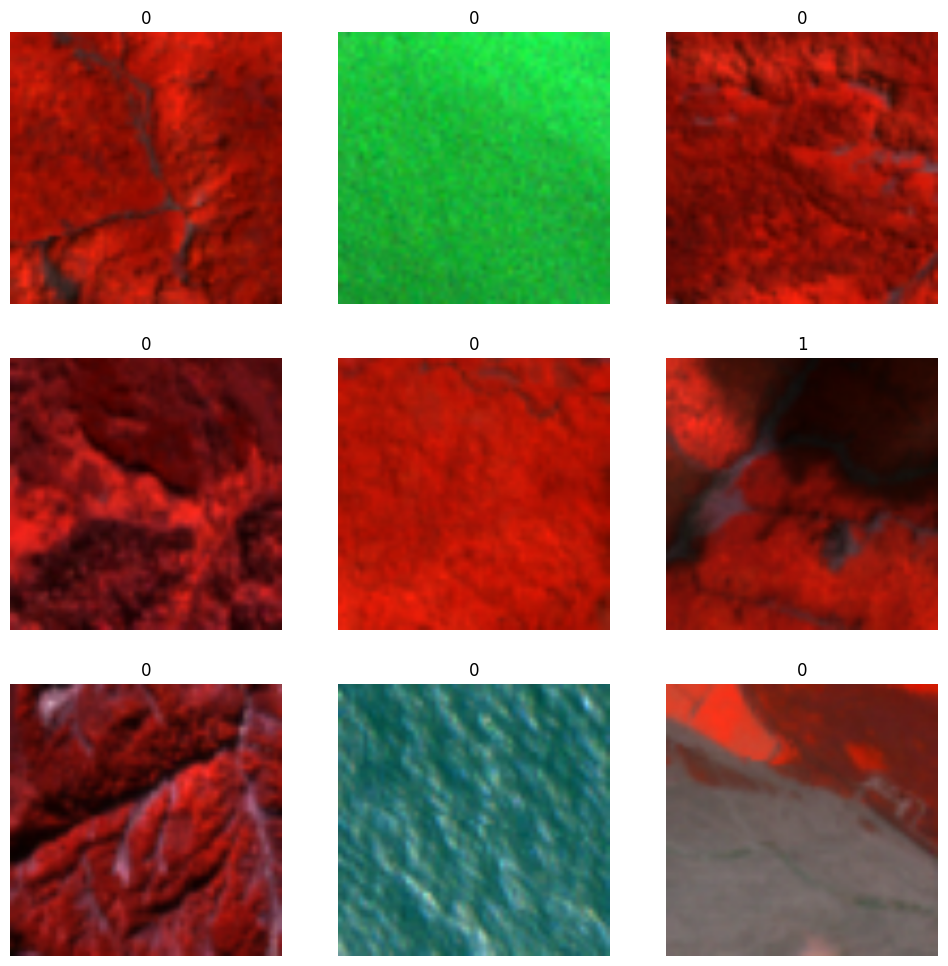

In [18]:
def get_datablock(train, fold=0, bs = CFG.batch_size):
  return DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_x = ColReader('image_path'),
      get_y = ColReader('label'),
      splitter = IndexSplitter(train[train['fold'] == fold].index),
      item_tfms = item_tfms,
      batch_tfms = batch_tfms
  ).dataloaders(train, bs=bs, seed= CFG.seed)

get_datablock(train).show_batch(figsize = (12,12))

In [19]:
f1_score = F1Score(average='binary')
metrics = [accuracy, f1_score]

In [ ]:
import gc

oof_preds = np.zeros((len(train), CFG.num_classes))
all_preds = []

for fold in range(CFG.n_splits):
    print(f"We are validating on fold : {fold} and training on fold: {[i for i in range(CFG.n_splits) if i != fold]}")
    print("-"* 100)
    dls = get_datablock(train, fold, CFG.batch_size)
    learn = vision_learner(
      dls,
      CFG.model_name,
      loss_func = CrossEntropyLossFlat(),
      metrics = metrics,
      cbs = [SaveModelCallback(monitor = 'f1_score', comp = np.greater)]
    )
    _valley, _slide = learn.lr_find(suggest_funcs=(valley, slide))
    learn.fine_tune(CFG.epochs , _valley)
    
    # Validation
    val_idx = dls.valid.items.index
    val_dl = learn.dls.valid
    val_preds, _ = learn.tta(dl= val_dl, n=CFG.tta)
    oof_preds[val_idx] = val_preds.numpy()
    
    #Inference
    test_dl = learn.dls.test_dl(test_df)
    preds, _ = learn.tta(dl= test_dl, n=CFG.tta)
    all_preds.append(preds.numpy())
    
    #clean up to free memory
    del learn, dls
    gc.collect()
    torch.cuda.empty_cache()
    # break



train['oof_preds'] = list(oof_preds)
display(train.head())

We are validating on fold : 0 and training on fold: [1, 2, 3, 4]
----------------------------------------------------------------------------------------------------


model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.510069,0.352091,0.860140,0.545455,04:37


Better model found at epoch 0 with f1_score value: 0.5454545454545455.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.394300,0.283537,0.886014,0.653928,06:47
1,0.383339,0.328027,0.877622,0.504249,06:47
2,0.359069,0.300615,0.866434,0.461972,06:47
3,0.324858,0.297806,0.868531,0.667845,06:47
4,0.248951,0.225494,0.911888,0.721239,06:47
5,0.326732,0.307386,0.865734,0.472527,06:47


Better model found at epoch 0 with f1_score value: 0.6539278131634819.
Better model found at epoch 3 with f1_score value: 0.667844522968198.
Better model found at epoch 4 with f1_score value: 0.7212389380530974.


In [ ]:
from sklearn.metrics import f1_score

train['predicted_label'] = train['oof_preds'].apply(
    lambda preds: 1 if preds[1] > 0.5 else 0
)
y_true = train['label'].apply(int).values
y_pred = train['predicted_label'].apply(int).values

print("F1_Score", f1_score(y_true, y_pred))

In [ ]:
all_preds_array = np.array([pred for pred in all_preds ])
mean_test_preds = all_preds_array.mean(axis = 0)
len(mean_test_preds)

In [ ]:
np.argmax(mean_test_preds, axis = 1)

In [ ]:
test_df['label'] = np.argmax(mean_test_preds, axis = 1)
test_df['label'].head()

In [ ]:
test_df['label'].value_counts()

In [ ]:
sub = test_df[['ID', 'label']]
sub.columns = ['ID', 'target']
sub.head()

In [ ]:
sub.to_csv(f"Break_100_{CFG.model_name}_all_folds.csv", index= False)

In [6]:
class LandslideDataset(Dataset):
    """
    PyTorch Dataset for landslide classification.
    
    Supports binary classification (landslide/no landslide)
    """
    
    def __init__(self, data_dir: str, image_ids: str, csv_file: str, class_mapping: Optional[Dict[str, int]] = None, transform: Optional[transforms.Compose] = None):
        """
        Initialize the landslide dataset.
        
        Args:
            image_ids: Image IDs of corresponding image in df
            csv_file: Path to CSV file with image paths and labels
            transform: Optional torchvision transforms
        """
        self.data_dir = data_dir
        self.transform = transform
        self.class_mapping = class_mapping
        self.image_ids = image_ids
        # Load CSV data
        self.df = pd.read_csv(csv_file)

    
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Get a sample from the dataset.
        
        Returns:
            Dictionary containing:
                - 'image': PIL Image or transformed tensor
                - 'label': Class label (integer)
                - 'image_path': Path to the image file
        """
        if idx >= self.image_ids.shape[0]:
            raise IndexError(f"Index {idx} >= dataset size {self.image_ids.shape[0]}")
            
        image_id = self.image_ids[idx]
        records = self.df[self.df["ID"] == image_id]
        
        label = records['label'].iloc[0]
        
        label = torch.tensor(label, dtype=torch.long)
        
        # Load image
        img_path = os.path.join(self.data_dir, f"{image_id}.npy")
        
        try:
            image = np.load(img_path)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        # Apply transforms
        if self.transform:
            # enhanced_img = self.create_spectral_indices(image)
            # feature_img = self.extract_advanced_features(image)
            # image = np.concatenate([enhanced_img, feature_img], axis=2)
            nir_first = image[:, :, [3, 1, 2, 0]] # nir, green, blue
            image = self.normalize_image(nir_first)
            image = image[:, :, :3]
            image = self.transform(image=image)
            aug_image = image["image"]
            
        return aug_image, label

    def normalize_image(self, band):
        # Nomalize image (0-255 range)
        band_min, band_max = (band.min(), band.max())
        band = ((band-band_min)/((band_max - band_min + 1e-6)))
        return (band*255).astype(np.uint8)

    def create_spectral_indices(self, image) -> np.concatenate:
        """
        Extract spectral bands from an image and concactenate
        
        Returns:
            List containing:
                - [image, indices]
        """
        # Extract individual bands
        red = image[:, :, 0]       # Band 1: Red
        green = image[:, :, 1]     # Band 2: Green
        blue = image[:, :, 2]      # Band 3: Blue
        nir = image[:, :, 3]       # Band 4: Near Infrared
        vv_desc = image[:, :, 4]   # Band 5: Descending VV
        vh_desc = image[:, :, 5]   # Band 6: Descending VH
        
        # Avoid division by zero
        epsilon = 1e-5
        
        # 1. NDVI (Normalized Difference Vegetation Index)
        ndvi = (nir - red) / (nir + red + epsilon)
        
        # 2. NDWI (Normalized Difference Water Index)
        ndwi = (green - nir) / (green + nir + epsilon)
        
        # 3. EVI (Enhanced Vegetation Index)
        # evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1 + epsilon))
        
        # 4. SAVI (Soil Adjusted Vegetation Index) - with L=0.5
        L = 0.5
        savi = ((nir - red) / (nir + red + L + epsilon)) * (1 + L)
        
        # 5. Radar Vegetation Index (using VV and VH)
        # rvi = 4 * vh_desc / (vv_desc + vh_desc + epsilon)
        
        # 6. Simple band ratio features
        # nir_red_ratio = nir / (red + epsilon)
        # vh_vv_ratio = vh_desc / (vv_desc + epsilon)
        
        
        # Stack the original image with the new indices
        # Reshape indices to match image dimensions for stacking
        # , nir_red_ratio, vh_vv_ratio'
        # rgb = np.stack([red, green, blue], axis=2)
        indices = np.stack([ndvi, ndwi, savi], axis=2)
        
        # Concatenate original image with new indices
        enhanced_image = np.concatenate([image, indices], axis=2)
        
        return enhanced_image

    def extract_advanced_features(self, img) -> np.stack:
        """Extract topographic and texture features from image bands."""
        
        elevation_proxy = img[:, :, 3]  # Near Infrared band
        
        # 1. Calculate slope (gradient magnitude)
        dx = ndimage.sobel(elevation_proxy, axis=0)
        dy = ndimage.sobel(elevation_proxy, axis=1)
        slope = np.hypot(dx, dy)  
        
        # 2. Calculate aspect (gradient direction)
        aspect = np.arctan2(dy, dx)
        
        # 3. Calculate curvature (approximation using Laplacian)
        curvature = ndimage.gaussian_filter(elevation_proxy, sigma=2) # smoothen first
        curvature = ndimage.laplace(curvature)
        
        # 4. Calculate texture features from GLCM (on SAR bands)
        # Rescale to 0-255 and convert to uint8 for GLCM
        # radar_band = img[:, :, 0]  # Using Descending VV polarization
        # radar_band_rescaled = (radar_band * 255).astype(np.uint8)
        
        # # Compute GLCM on a downsampled version if memory is an issue
        # step_size = 2  # Skip pixels to reduce computation
        # distances = [1]  # Pixel pairs 1 pixel apart
        # angles = [0, 45, 90, 135]  # 0, 45, 90, 135 degrees
        
        # glcm = graycomatrix(radar_band_rescaled[::step_size, ::step_size], 
        #                     distances=distances, angles=angles, 
        #                     levels=256, symmetric=True, normed=True)
        
        # # Extract properties
        # contrast = graycoprops(glcm, 'contrast').mean()
        # dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
        # homogeneity = graycoprops(glcm, 'homogeneity').mean()
        # # energy = graycoprops(glcm, 'energy').mean()
        # correlation = graycoprops(glcm, 'correlation').mean()
        # mean = graycoprops(glcm, 'mean').mean()
        # variance = graycoprops(glcm, 'variance').mean()
        # entropy = graycoprops(glcm, 'entropy').mean()
        
        # # Create uniform-sized feature maps from scalar GLCM stats
        # h, w = img.shape[0], img.shape[1]
        # contrast_map = np.ones((h, w)) * contrast
        # dissimilarity_map = np.ones((h, w)) * dissimilarity
        # homogeneity_map = np.ones((h, w)) * homogeneity
        # # energy_map = np.ones((h, w)) * energy
        # correlation_map = np.ones((h, w)) * correlation
        # mean_map = np.ones((h, w)) * mean
        # variance_map = np.ones((h, w)) * variance
        # entropy_map = np.ones((h, w)) * entropy
    
        # print("Homogeneity range:", np.min(homogeneity_map), np.max(homogeneity_map))
        # print("Entropy range:", np.min(entropy_map), np.max(entropy_map))
        # print("Correlation range:", np.min(correlation_map), np.max(correlation_map))
        # print("Mean range:", np.min(mean_map), np.max(mean_map))
        
        
        # Stack features as additional bands
        topo_texture_features = np.stack([
            slope, aspect, curvature
            # contrast_map, dissimilarity_map, homogeneity_map, 
            # entropy_map, correlation_map, mean_map, variance_map
        ], axis=2)
        
        return topo_texture_features

    def get_class_weights(self) -> torch.Tensor:
        """Calculate class weights for handling imbalanced datasets."""
        label_counts = self.df['label'].value_counts()
        weights = []
        
        for class_name, class_idx in self.class_mapping.items():
            count = label_counts.get(class_name, 1)  # Avoid division by zero
            weight = len(self.df) / (self.num_classes * count)
            weights.append(weight)
            
        return torch.tensor(weights, dtype=torch.float32)
    
    def get_class_distribution(self) -> Dict[str, int]:
        """Get the distribution of classes in the dataset."""
        return self.df['label'].value_counts().to_dict()


### Set Transforms

In [7]:
def get_default_transforms(image_size: Tuple[int, int] = (224, 224), is_train: bool = True) -> A.Compose:
    """
    Get default image transforms for landslide classification.
    
    Args:
        image_size: Target image size (height, width)
        is_training: Whether this is for training (includes augmentation)
    """
    if is_train:
        tfms = [
            A.Resize(height=image_size[0], width=image_size[1]),
            A.RandomResizedCrop(image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            A.ToTensorV2()
        ]
    else:
        tfms = [
            A.Resize(height=image_size[0], width=image_size[1]),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            A.ToTensorV2()
        ]
    
    return A.Compose(tfms)

### Set DataLoaders

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

def create_data_loaders(
    train_dataset: Optional[LandslideDataset] = None,
    val_dataset: Optional[LandslideDataset] = None,
    test_dataset: Optional[LandslideDataset] = None,
    batch_size: int = 32,
    num_workers: int = 4,
    pin_memory: bool = True,
    collate_fn: tuple = collate_fn,
    persistent_workers: bool = True
) -> Dict[str, DataLoader]:
    """
    Create DataLoaders for training, validation, and testing.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset (optional)
        test_dataset: Test dataset (optional)
        batch_size: Batch size for all dataloaders
        num_workers: Number of worker processes
        pin_memory: Whether to pin memory for faster GPU transfer
    
    Returns:
        Dictionary containing DataLoaders
    """
    dataloaders = {}
    
    # Training loader with shuffling
    if train_dataset is not None:
        dataloaders['train'] = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            persistent_workers=persistent_workers,
            drop_last=True
        )
    
    # Validation loader
    if val_dataset is not None:
        dataloaders['val'] = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            persistent_workers=persistent_workers
        )
    
    # Test loader
    if test_dataset is not None:
        dataloaders['test'] = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            persistent_workers=persistent_workers
        )
    
    return dataloaders

In [9]:
class MultiSpectralLandslideClassifier(nn.Module):
    """
    Multi-spectral landslide classification model using pretrained backbones.
    """
    
    def __init__(
        self,
        num_classes: int = 2,
        in_channels: int = 3,
        backbone: str = 'convnext_tiny',
        pretrained: bool = True,
        dropout_rate: float = 0.5,
        freeze_backbone: bool = False,
        freeze_layers: int = 0
    ):
        """
        Args:
            num_classes: Number of output classes
            in_channels: Number of input spectral channels
            backbone: Pretrained model backbone ('resnet50', 'efficientnet_b0', 'vgg16')
            pretrained: Whether to use pretrained weights
            dropout_rate: Dropout rate for classifier head
            freeze_backbone: Whether to freeze backbone parameters
            freeze_layers: Number of initial layers to freeze (if freeze_backbone=False)
        """
        super().__init__()
        
        self.num_classes = num_classes
        self.in_channels = in_channels
        
        # Load pretrained backbone
        self.backbone, self.feature_dim = self._load_backbone(backbone, pretrained)
        
        # Freeze backbone if requested
        if freeze_backbone:
            self._freeze_backbone()
        elif freeze_layers > 0:
            self._freeze_layers(freeze_layers)
        
        # Classifier head
        classifier_input_dim = self.feature_dim
        # if use_metadata:
        #     classifier_input_dim += metadata_dim
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
        # Initialize classifier weights
        self._init_classifier_weights()
    
    def _load_backbone(self, backbone: str, pretrained: bool) -> Tuple[nn.Module, int]:
        """Load and configure the pretrained backbone."""
        if backbone.lower() == 'resnet50':
            if pretrained:
                model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
            else:
                model = models.resnet50(weights=None)
            # Remove final classification layer
            feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = 2048
            
        elif backbone.lower() == 'convnext_tiny':
            if pretrained:
                model = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
            else:
                model = models.convnext_tiny(weights=None)
            feature_extractor = model.features
            feature_dim = 1280
            
        elif backbone.lower() == 'convnext_large':
            if pretrained:
                model = models.convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)
            else:
                model = models.convnext_large(weights=None)
            feature_extractor = model.features
            feature_dim = 512
            
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        return feature_extractor, feature_dim
    
    def _freeze_backbone(self):
        """Freeze all backbone parameters."""
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def _freeze_layers(self, num_layers: int):
        """Freeze specified number of initial layers."""
        layers = list(self.backbone.children())
        for i, layer in enumerate(layers[:num_layers]):
            for param in layer.parameters():
                param.requires_grad = False
    
    def _init_classifier_weights(self):
        """Initialize classifier weights."""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (B, in_channels, H, W)
            metadata: Optional metadata tensor of shape (B, metadata_dim)
        
        Returns:
            Logits tensor of shape (B, num_classes)
        """
        # Adapt multi-spectral to RGB if necessary
        # if self.spectral_adapter is not None:
        #     x = self.spectral_adapter(x)
        
        # Extract features using backbone
        features = self.backbone(x)
        
        # Handle different backbone output formats
        if len(features.shape) == 4:  # For models that don't include global pooling
            features = F.adaptive_avg_pool2d(features, (1, 1))
        
        features = features.view(features.size(0), -1)  # Flatten
        
        # Classification
        logits = self.classifier[3:](features)  # Skip the pooling and flatten layers
        
        return logits
    
    def get_feature_maps(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extract feature maps for visualization or analysis.
        
        Args:
            x: Input tensor of shape (B, in_channels, H, W)
            
        Returns:
            Feature maps from the backbone
        """
        # if self.spectral_adapter is not None:
        #     x = self.spectral_adapter(x)
        
        # Get intermediate features
        if hasattr(self.backbone, 'features'):  # For VGG, EfficientNet
            return self.backbone.features(x)
        else:  # For ResNet
            return self.backbone(x)

In [10]:
def create_multispectral_model(
    num_classes: int,
    in_channels: int,
    backbone: str = 'convnext_tiny',
    **kwargs
) -> MultiSpectralLandslideClassifier:
    """
    Factory function to create a multi-spectral landslide classification model.
    
    Args:
        num_classes: Number of output classes
        in_channels: Number of input spectral channels
        backbone: Pretrained backbone to use
        **kwargs: Additional arguments for the model
    
    Returns:
        Configured model instance
    """
    return MultiSpectralLandslideClassifier(
        num_classes=num_classes,
        in_channels=in_channels,
        backbone=backbone,
        **kwargs
    )

### Average Meter to output average of losses at the end of each epoch

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### focal loss as criterion for imbalanced datasets

In [12]:
class FocalLoss(nn.Module):
    """
    Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param reduction: `none`|`mean`|`sum`
    """

    def __init__(self, alpha=1, gamma=2, reduction='mean', **kwargs):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-6  # set '1e-4' when train with FP16
        self.reduction = reduction

        assert self.reduction in ['none', 'mean', 'sum']

    def forward(self, output, target):
        prob = torch.sigmoid(output)
        prob = torch.clamp(prob, self.smooth, 1.0 - self.smooth)

        target = target.unsqueeze(dim=1)
        pos_mask = (target == 1).float()
        neg_mask = (target == 0).float()

        pos_weight = (pos_mask * torch.pow(1 - prob, self.gamma)).detach()
        pos_loss = -pos_weight * torch.log(prob)  # / (torch.sum(pos_weight) + 1e-4)

        neg_weight = (neg_mask * torch.pow(prob, self.gamma)).detach()
        neg_loss = -self.alpha * neg_weight * F.logsigmoid(-output)  # / (torch.sum(neg_weight) + 1e-4)

        loss = pos_loss + neg_loss
        loss = loss.mean()
        return loss

### train function

In [13]:
batch_size = 32

def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()
    f1_metric = F1Score(task="binary").to(device)

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, label) in enumerate(tk0):

        images = torch.stack([image.to(device) for image in images])
        labels = torch.stack(label).to(device)
        # targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        output = model(images)

        losses = criterion(output, labels)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()

        predicted_labels = torch.argmax(output, dim=1)
        
        if scheduler is not None:
            scheduler.step()

        f1_metric.update(predicted_labels, labels)
        summary_loss.update(losses.item(),batch_size)
        f1_loss = f1_metric.compute()
        
        tk0.set_postfix(loss=summary_loss.avg)
        # tk0.set_postfix(loss=f1_loss)
        

    return summary_loss, f1_loss

### val function

In [14]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    
    summary_loss = AverageMeter()
    f1_metric = F1Score(task="binary").to(device)

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, label) in enumerate(tk0):

            images = torch.stack([image.to(device) for image in images])
            labels = torch.stack(label).to(device)
            
            # targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            losses = criterion(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            
            f1_metric.update(predicted_labels, labels)
            summary_loss.update(losses.item(),batch_size)
            f1_loss = f1_metric.compute()
            
            tk0.set_postfix(loss=summary_loss.avg)
            # tk0.set_postfix(loss=f1_loss)

    return summary_loss, f1_loss

### main training loop

In [17]:
train_transform = get_default_transforms(is_train=True)
val_transform = get_default_transforms(is_train=False)

def run(fold, train, df_folds, epochs=10, batch_size=16):

    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = LandslideDataset(
        data_dir=train_imgs,
        image_ids=df_train.ID.values,
        csv_file=train_dir,
        transform=train_transform
    )

    valid_dataset = LandslideDataset(
        data_dir=train_imgs,
        image_ids=df_valid.ID.values,
        csv_file=train_dir,
        transform=train_transform
    )

    dataloaders = create_data_loaders(
        train_dataset=train_dataset,
        val_dataset=valid_dataset,
        batch_size=batch_size,
        num_workers=2,
        persistent_workers=True
    )

    train_loader = dataloaders['train']
    val_loader = dataloaders['val']
    # batch = next(iter(train_loader))

    num_classes = train['label'].nunique()
    losses = ['label']

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # model = create_multispectral_model(
    #     num_classes=2,  # landslide, no_landslide
    #     in_channels=3,  # multispectral
    #     backbone='efficientnet_b0',
    #     pretrained=True,
    #     dropout_rate=0.3
    # )
    # model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    # num_ftrs = model.classifier[2].in_features # Get input features of the last layer
    # model.classifier[2] = nn.Linear(num_ftrs, num_classes) # Replace with a new layer
    
    model = timm.create_model('beit_large_patch16_224.in22k_ft_in22k_in1k', pretrained=True, num_classes=num_classes)
    model = model.to(device)
    # criterion = FocalLoss()
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)


    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    best_f1 = 0.002
    for epoch in range(epochs):
        train_loss, train_f1_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss, val_f1_loss = eval_fn(val_loader, model,criterion, device)

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}| TRAIN_F1_METRIC {}| VALID_F1_METRIC {}|'.format(epoch+1,train_loss.avg,valid_loss.avg, train_f1_loss, val_f1_loss))
        
        # train_f1_loss.reset()
        # val_f1_loss.reset()
        
        if val_f1_loss > best_f1:
            best_f1 = val_f1_loss
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'landslide_best_{fold}.pth')


In [18]:
if __name__ == '__main__':

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    id_labels = train.groupby('ID')['label'].agg(
        lambda x: x.iloc[0]
    ).reset_index()

    for fold_number, (train_index, val_index) in enumerate(skf.split(X=id_labels['ID'], y=id_labels['label'])):
        id_labels.loc[id_labels.iloc[val_index].index, 'fold'] = fold_number

    
    run(fold=2, train=train, df_folds=id_labels, epochs=12)

model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 0.34917352094474124| VALID_LOSS 0.24822252922587926| TRAIN_F1_METRIC 0.4169014096260071| VALID_F1_METRIC 0.6965811848640442|
Best model found for Fold 2 in Epoch 1........Saving Model


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 0.24142513989734382| VALID_LOSS 0.2525472203269601| TRAIN_F1_METRIC 0.6853448152542114| VALID_F1_METRIC 0.6157760620117188|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.22150227925231478| VALID_LOSS 0.20757034147779146| TRAIN_F1_METRIC 0.7228109240531921| VALID_F1_METRIC 0.7560439705848694|
Best model found for Fold 2 in Epoch 3........Saving Model


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.19755624780426173| VALID_LOSS 0.2130742621401118| TRAIN_F1_METRIC 0.7640449404716492| VALID_F1_METRIC 0.7345132827758789|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.18051198778637484| VALID_LOSS 0.19862339072343377| TRAIN_F1_METRIC 0.7807430624961853| VALID_F1_METRIC 0.7489361763000488|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 0.16681774416860162| VALID_LOSS 0.19943072480253046| TRAIN_F1_METRIC 0.801886796951294| VALID_F1_METRIC 0.7361419200897217|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 0.16017988555039428| VALID_LOSS 0.1709313722844753| TRAIN_F1_METRIC 0.8118081092834473| VALID_F1_METRIC 0.7992125749588013|
Best model found for Fold 2 in Epoch 7........Saving Model


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 0.15572045834771558| VALID_LOSS 0.18788834582600328| TRAIN_F1_METRIC 0.8176563382148743| VALID_F1_METRIC 0.7797356843948364|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 0.14706327324388785| VALID_LOSS 0.17950232875947322| TRAIN_F1_METRIC 0.8293713927268982| VALID_F1_METRIC 0.7939913868904114|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 0.128894016433622| VALID_LOSS 0.19841742679062818| TRAIN_F1_METRIC 0.8581855893135071| VALID_F1_METRIC 0.7747035622596741|


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 11| TRAIN_LOSS 0.14041924679323153| VALID_LOSS 0.1919809339257578| TRAIN_F1_METRIC 0.8382274508476257| VALID_F1_METRIC 0.8007736802101135|
Best model found for Fold 2 in Epoch 11........Saving Model


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

|EPOCH 12| TRAIN_LOSS 0.12379382572108123| VALID_LOSS 0.16218598978593946| TRAIN_F1_METRIC 0.8584856390953064| VALID_F1_METRIC 0.8043010830879211|
Best model found for Fold 2 in Epoch 12........Saving Model


In [19]:
# if __name__ == '__main__':
#    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#    id_labels = train.groupby('ID')['label'].agg(
#        lambda x: x.iloc[0]
#    ).reset_index()
#    id_labels['fold'] = -1  # Initialize fold column
   
#    for fold_number, (train_index, val_index) in enumerate(skf.split(X=id_labels['ID'], y=id_labels['label'])):
#        id_labels.loc[val_index, 'fold'] = fold_number
   
#    # Train all folds
#    for fold in range(5):
#        print(f"\n=== Training Fold {fold} ===")
#        run(fold=fold, train=train, df_folds=id_labels, epochs=5)

### Inference

In [20]:
class TestLandslideDataset(Dataset):
    """
    PyTorch Dataset for landslide classification.
    
    Supports binary classification (landslide/no landslide)
    """
    
    def __init__(self, data_dir: str, image_ids: str, csv_file: str, class_mapping: Optional[Dict[str, int]] = None, transform: Optional[transforms.Compose] = None):
        """
        Initialize the landslide dataset.
        
        Args:
            image_ids: Image IDs of corresponding image in df
            csv_file: Path to CSV file with image paths and labels
            transform: Optional torchvision transforms
        """
        self.data_dir = data_dir
        self.transform = transform
        self.class_mapping = class_mapping
        self.image_ids = image_ids
        # Load CSV data
        self.df = pd.read_csv(csv_file)

    
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Get a sample from the dataset.
        
        Returns:
            Dictionary containing:
                - 'image': PIL Image or transformed tensor
                - 'image_path': Path to the image file
        """
        if idx >= self.image_ids.shape[0]:
            raise IndexError(f"Index {idx} >= dataset size {self.image_ids.shape[0]}")
            
        image_id = self.image_ids[idx]
        records = self.df[self.df["ID"] == image_id]
        
        # Load image
        img_path = os.path.join(self.data_dir, f"{image_id}.npy")
        
        try:
            image = np.load(img_path)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        # Apply transforms
        if self.transform:
            # enhanced_img, nir_first = self.create_spectral_indices(image)
            # feature_img = self.extract_advanced_features(image)
            # image = np.concatenate([enhanced_img, feature_img], axis=2)
            # image = self.normalize_image(image)
            nir_first = image[:, :, [3, 1, 2, 0]]
            image = nir_first[:, :, :3]
            image = self.transform(image=image)
            aug_image = image["image"]
            
        return aug_image, image_id

    def normalize_image(self, band):
        # Nomalize image (0-1 range)
        band_min, band_max = (band.min(), band.max())
        return ((band-band_min)/((band_max - band_min)))

    def create_spectral_indices(self, image) -> np.concatenate:
        """
        Extract spectral bands from an image and concactenate
        
        Returns:
            List containing:
                - [image, indices]
        """
        # Extract individual bands
        red = image[:, :, 0]       # Band 1: Red
        green = image[:, :, 1]     # Band 2: Green
        blue = image[:, :, 2]      # Band 3: Blue
        nir = image[:, :, 3]       # Band 4: Near Infrared
        vv_desc = image[:, :, 4]   # Band 5: Descending VV
        vh_desc = image[:, :, 5]   # Band 6: Descending VH
        
        # Avoid division by zero
        epsilon = 1e-5
        
        # 1. NDVI (Normalized Difference Vegetation Index)
        ndvi = (nir - red) / (nir + red + epsilon)
        
        # 2. NDWI (Normalized Difference Water Index)
        ndwi = (green - nir) / (green + nir + epsilon)
        
        # 3. EVI (Enhanced Vegetation Index)
        # evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1 + epsilon))
        
        # 4. SAVI (Soil Adjusted Vegetation Index) - with L=0.5
        L = 0.5
        savi = ((nir - red) / (nir + red + L + epsilon)) * (1 + L)
        
        # 5. Radar Vegetation Index (using VV and VH)
        # rvi = 4 * vh_desc / (vv_desc + vh_desc + epsilon)
        
        # 6. Simple band ratio features
        # nir_red_ratio = nir / (red + epsilon)
        # vh_vv_ratio = vh_desc / (vv_desc + epsilon)
        
        # Stack the original image with the new indices
        # Reshape indices to match image dimensions for stacking
        # , nir_red_ratio, vh_vv_ratio'
        # rgb = np.stack([red, green, blue], axis=2)
        indices = np.stack([ndvi, ndwi, savi], axis=2)
        
        # Concatenate original image with new indices
        enhanced_image = np.concatenate([image, indices], axis=2)
        
        return enhanced_image

    def extract_advanced_features(self, img) -> np.stack:
        """Extract topographic and texture features from image bands."""
        
        elevation_proxy = img[:, :, 3]  # Near Infrared band
        
        # 1. Calculate slope (gradient magnitude)
        dx = ndimage.sobel(elevation_proxy, axis=0)
        dy = ndimage.sobel(elevation_proxy, axis=1)
        slope = np.hypot(dx, dy)  
        
        # 2. Calculate aspect (gradient direction)
        aspect = np.arctan2(dy, dx)
        
        # 3. Calculate curvature (approximation using Laplacian)
        curvature = ndimage.gaussian_filter(elevation_proxy, sigma=2) # smoothen first
        curvature = ndimage.laplace(curvature)
        
        # 4. Calculate texture features from GLCM (on SAR bands)
        # Rescale to 0-255 and convert to uint8 for GLCM
        # radar_band = img[:, :, 0]  # Using Descending VV polarization
        # radar_band_rescaled = (radar_band * 255).astype(np.uint8)
        
        # # Compute GLCM on a downsampled version if memory is an issue
        # step_size = 2  # Skip pixels to reduce computation
        # distances = [1]  # Pixel pairs 1 pixel apart
        # angles = [0, 45, 90, 135]  # 0, 45, 90, 135 degrees
        
        # glcm = graycomatrix(radar_band_rescaled[::step_size, ::step_size], 
        #                     distances=distances, angles=angles, 
        #                     levels=256, symmetric=True, normed=True)
        
        # # Extract properties
        # contrast = graycoprops(glcm, 'contrast').mean()
        # dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
        # homogeneity = graycoprops(glcm, 'homogeneity').mean()
        # # energy = graycoprops(glcm, 'energy').mean()
        # correlation = graycoprops(glcm, 'correlation').mean()
        # mean = graycoprops(glcm, 'mean').mean()
        # variance = graycoprops(glcm, 'variance').mean()
        # entropy = graycoprops(glcm, 'entropy').mean()
        
        # # Create uniform-sized feature maps from scalar GLCM stats
        # h, w = img.shape[0], img.shape[1]
        # contrast_map = np.ones((h, w)) * contrast
        # dissimilarity_map = np.ones((h, w)) * dissimilarity
        # homogeneity_map = np.ones((h, w)) * homogeneity
        # # energy_map = np.ones((h, w)) * energy
        # correlation_map = np.ones((h, w)) * correlation
        # mean_map = np.ones((h, w)) * mean
        # variance_map = np.ones((h, w)) * variance
        # entropy_map = np.ones((h, w)) * entropy
    
        # print("Homogeneity range:", np.min(homogeneity_map), np.max(homogeneity_map))
        # print("Entropy range:", np.min(entropy_map), np.max(entropy_map))
        # print("Correlation range:", np.min(correlation_map), np.max(correlation_map))
        # print("Mean range:", np.min(mean_map), np.max(mean_map))
        
        
        # Stack features as additional bands
        topo_texture_features = np.stack([
            slope, aspect, curvature
            # contrast_map, dissimilarity_map, homogeneity_map, 
            # entropy_map, correlation_map, mean_map, variance_map
        ], axis=2)
        
        return topo_texture_features


In [21]:
test_dataset = TestLandslideDataset(
    data_dir=test_imgs,
    image_ids=test.ID.values,
    csv_file=test_dir,
    transform=val_transform
)

dataloaders = create_data_loaders(
    test_dataset=test_dataset,
    batch_size=16,
    num_workers=2
)

test_loader = dataloaders['test']
model_path = "/kaggle/working/landslide_best_2.pth"

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def predict(model_path, data_loader):
    model = timm.create_model('beit_large_patch16_224.in22k_ft_in22k_in1k', pretrained=True, num_classes=2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    predictions = []
    image_ids = []
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    with torch.no_grad():
        for step, (images, image_id) in enumerate(tk0):
            inputs = torch.stack([image for image in images])
            # print(inputs.shape)
            outputs = model(inputs)

            _, predicted_classes = torch.max(outputs, 1)
            predictions.extend(predicted_classes.cpu().numpy())
            image_ids.extend(image_id)
    return predictions, image_ids


predictions, ids = predict(model_path, test_loader)
# print(results)

  0%|          | 0/338 [00:00<?, ?it/s]

In [23]:
len(predictions)

5398

In [24]:
submission_df = pd.DataFrame({
    'ID': ids,
    'label': predictions # Flatten to match submission format
})
submission_df.to_csv('torch_beit_0804_large.csv', index=False)
print("Sample submission file created as 'torch_first.csv'.")

Sample submission file created as 'torch_first.csv'.
